Import libraries

In [54]:
import os
from pathlib import Path

import sys
sys.path.append("../")
from src.utils import get_device
from going_modular import data_setup, engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.notebook import tqdm

print(torch.__version__)

2.0.0


Setup hyperparameters

In [28]:
BATCH_SIZE = 32
NUM_WORKERS = 0 # MPS cannot work with more than 0
EPOCHS = 3
LR = 0.001
SEED = 42

Setup torch device

In [5]:
device = get_device()
device

'mps'

Setup data directories

In [7]:
data_path = Path("data/")
train_dir = data_path / "pizza_steak_sushi/train"
test_dir = data_path / "pizza_steak_sushi/test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Setup dataloaders manually
* For transfer learning, be sure to transform input images in the way that the model expects
> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
> The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [9]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    normalize
])

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = BATCH_SIZE
)

class_names

['pizza', 'steak', 'sushi']

Setup dataloaders automatically for `torchvision.models`
> As of torchvision v0.13+ there is now support for automatic data transform creation based on the pre-trained model weights you're using

In [12]:
import torchvision
print(torchvision.__version__)

0.15.1


In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# Get transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = BATCH_SIZE
)

class_names

['pizza', 'steak', 'sushi']

Getting a pretrained model. The 4 main model hubs are:
1. PyTorch domain libraries
2. Libraries like `timm`
3. HuggingFace Hub
4. Papers with code

> When choosing a model, speed, size and performance (inference speed) are the most important considerations. 

In [45]:
model = torchvision.models.efficientnet_b0(weights = weights)
summary(model = model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

These are our features extractor layers

In [19]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

These collect the features extracted by the model and average them (downsampling)

In [20]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

Notice that the out_features is 1000! That's because the model was trained on the ImageNet data subset with 1000 different classes. We need to change this to 3 because we only have 3 different classes

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

We are going to keep the base layers (feature extraction layers) frozen, and only unfreeze the output layer. So we're essentially using the pre-trained model as a large feature extractor. When finetuning further, we can unfreeze layer by layer from the top (nearest to the classifier) down.

In [46]:
### Freezing base model and changing the output layer to suit our needs
for param in model.features.parameters():
    param.requires_grad = False

summary(model = model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [37]:
# Original model classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [47]:
### Update the classifier head of our model

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True))

In [48]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [49]:
summary(model = model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Notice the dip in the number of parameters!

## Training the model

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = LR)

In [51]:
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model = model.to(device),
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = EPOCHS,
                       device = device)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0815 | train_acc: 0.4023 | test_loss: 0.8985 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.8574 | train_acc: 0.7734 | test_loss: 0.7932 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7885 | train_acc: 0.7930 | test_loss: 0.7392 | test_acc: 0.8561
[INFO] Total training time: 184.969 seconds


In [56]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

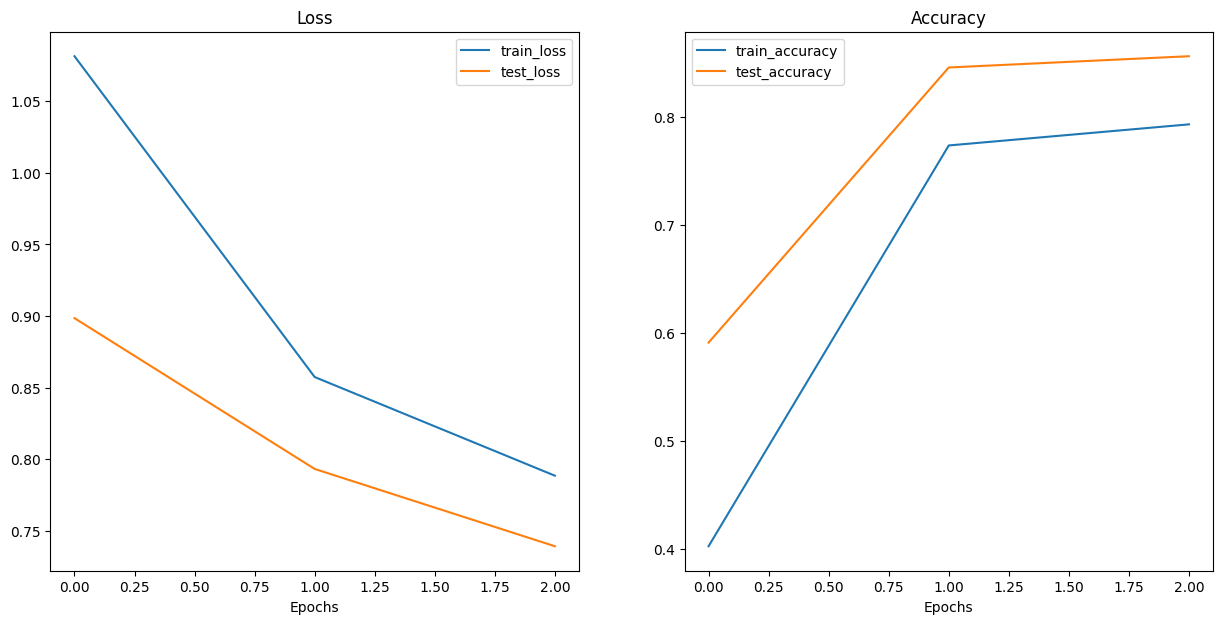

In [57]:
plot_loss_curves(results)

The improvement in model accuracy is very stark. But it's quite strange that the test accuracy is better than the training accuracy. This does suggest that the results might not be as reliable as we think.

### Predicting and plotting images using our model

In [133]:
from PIL import Image
from typing import List, Tuple

def infer(model: torch.nn.Module, 
          class_names: List,
          filepath: str,
          img_size: Tuple[int, int] = (224, 224),
          transform: torchvision.transforms = None,
          device: torch.device = device):
    
    img = Image.open(filepath)
    if transform is not None:
        img_transformed = transform(img)
    else:
        transform = transforms.Compose([
            transforms.Resize((img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
        ])
        img_transformed = transform(img)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        logits = model(img_transformed.unsqueeze(dim = 0).to(device))
    
    probs = torch.softmax(logits, dim = 1).to('cpu')
    pred = torch.argmax(probs, dim = 1)
    
    plt.figure(figsize = (10,7))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred]} | Prob {probs.max():.3f}")
    plt.axis(False);
    plt.show()    

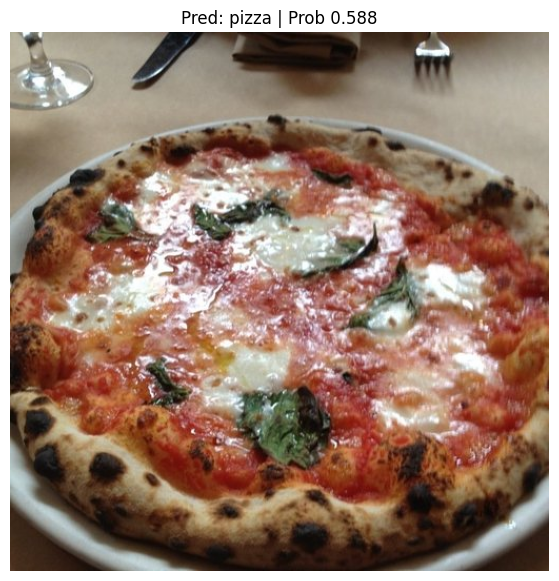

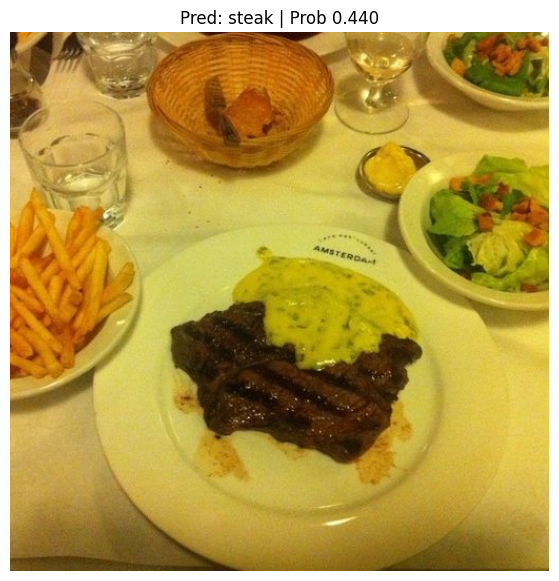

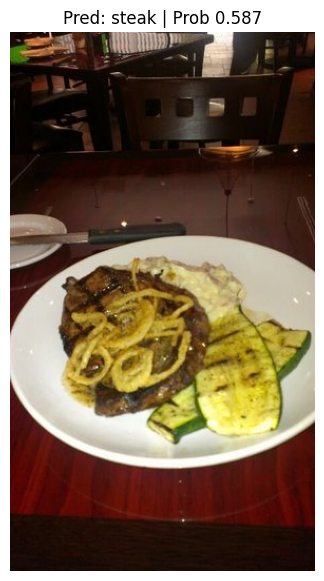

In [135]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)
for img in test_image_path_sample:
      infer(model = model,
            filepath = img,
            class_names = class_names,
            transform = auto_transforms)

Notice that the probabilities are not so high even though it appears to be getting it right